# Greedy Algorithm Benchmarking (KNN)

This notebook serves to benchmark VanillaGreedySolver with our missing data imputation functions that utilize KNN.

You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/latest/installation.html).

All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/latest/).

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import random

import cassiopeia as cas

## Building benchmarking pipeline

The benchmarking pipeline consists of:

1. Simulating a ground truth phylogeny
2. Overlaying data onto this phylogeny
3. Inferring the phylogeny with potentially many algorithms
4. Assessing performance

Setting up necessary variables
- `algorithm` = The algorithms we will compare
- `bd_sim` = Simulates a birth-death process for creating a ground truth tree
- `lt_sim` = Uses a Cas9-based lineage tracing data simulator for overlaying data

In [2]:
algorithms = {
    "Vanilla Greedy": cas.solver.VanillaGreedySolver(),
    "k=1": cas.solver.VanillaGreedySolver(),
    "k=3": cas.solver.VanillaGreedySolver(),
    "k=5": cas.solver.VanillaGreedySolver(),
    # can add more algorithms here
}

bd_sim = cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution=lambda scale: np.random.exponential(scale),
    initial_birth_scale=0.5,
    death_waiting_distribution=lambda: np.random.exponential(1.5),
    mutation_distribution=lambda: 1 if np.random.uniform() < 0.5 else 0,
    fitness_distribution=lambda: np.random.normal(0, 0.5),
    fitness_base=1.3,
    num_extant=400,
    random_seed=17,
)

np.random.seed(seed=None)
lt_sim = cas.sim.Cas9LineageTracingDataSimulator(
    number_of_cassettes=40,
    size_of_cassette=1,
    mutation_rate=0.1,
    state_generating_distribution=lambda: np.random.exponential(1e-5),
    number_of_states=50,
    state_priors=None,
    heritable_silencing_rate=9e-4,
    stochastic_silencing_rate=0.1,
    heritable_missing_data_state=-1,
    stochastic_missing_data_state=-1,
)

In [3]:
# Main Benchmark Code


def impute_chr_mat(chr_mat, p=1, deterministic=False, k=1):
    def score(lst1, lst2):
        score = 0
        for i in range(len(lst1)):
            if lst1[i] == lst2[i]:
                score += 1
        return score

    chr_mat_copy = chr_mat.copy(deep=True)
    for c in chr_mat_copy.columns:
        # print(c)

        chr_mat_copy.sort_values(by=c, axis=0, inplace=True)

        missing = []
        labeled = []

        for r in chr_mat_copy.index:
            if chr_mat_copy[c][r] == -1:
                missing.append(r)
            else:
                labeled.append(r)

        labeled = np.array(labeled)

        for m in range(len(missing)):
            scores = []
            # max_score = 0
            # idx = 0
            for l in range(len(labeled)):
                s = score(
                    chr_mat.iloc[m].values.tolist(),
                    chr_mat.iloc[len(missing) + l].values.tolist(),
                )
                scores.append(s)
                # if s > max_score:
                #   max_score = s
                #   idx = l

            scores = np.array(scores)

            # Impute with 75% probability
            if random.random() <= p:
                if deterministic:
                    lst = list(labeled[np.argsort(scores)[:k]])
                    # print(lst)
                    pred = max(set(lst), key=lst.count)
                else:
                    pred = random.choices(labeled, weights=scores)[0]
                chr_mat_copy[c][missing[m]] = chr_mat_copy[c][pred]

    chr_mat_copy.sort_index(inplace=True)

    return chr_mat_copy

    # print(missing)
    # print(labeled)

    # Separate column into cells with missing values and cells without missing values
    # For each missing value
    # Iterate through the cells without the missing value. Determine a
    # similarity score (+1) if matching mutation or both missing, (+0) if not
    # Form the probability distribution based on similarity score


iterations = 10
algorithm_to_performance_triplets = defaultdict(list)
algorithm_to_performance_rf = defaultdict(list)

for _ in tqdm(range(iterations)):
    ground_truth_tree = bd_sim.simulate_tree()

    np.random.seed(None)
    lt_sim.overlay_data(ground_truth_tree)

    for algorithm_name in tqdm(algorithms.keys()):
        algorithm = algorithms[algorithm_name]
        cm = ground_truth_tree.character_matrix
        if algorithm_name == "k=1":
            cm = impute_chr_mat(cm, 1, True, 1)
        if algorithm_name == "k=3":
            cm = impute_chr_mat(cm, 1, True, 3)
        if algorithm_name == "k=5":
            cm = impute_chr_mat(cm, 1, True, 5)

        reconstructed_tree = cas.data.CassiopeiaTree(
            character_matrix=cm,
            missing_state_indicator=-1,
        )

        algorithm.solve(reconstructed_tree)

        # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
        reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters=True)

        rf, rf_max = cas.critique.compare.robinson_foulds(
            ground_truth_tree, reconstructed_tree
        )

        triplets = cas.critique.compare.triplets_correct(
            ground_truth_tree, reconstructed_tree, number_of_trials=500
        )
        algorithm_to_performance_triplets[algorithm_name].append(
            np.mean(list(triplets[0].values()))
        )

        algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

**Visualising Results**

We will visualize the results by looking at two metrics offered by the Cassiopeia `critique` library:

- Triplets Correct Measure
- Robinson-Foulds Distance

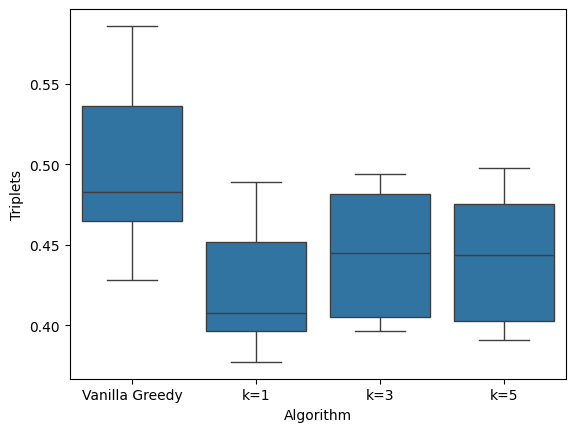

                count      mean       std       min       25%       50%  \
Algorithm                                                                 
Vanilla Greedy   10.0  0.498078  0.055297  0.428000  0.464583  0.482722   
k=1              10.0  0.423744  0.037976  0.377222  0.396361  0.407389   
k=3              10.0  0.445078  0.040219  0.396444  0.405167  0.444667   
k=5              10.0  0.441667  0.040326  0.390667  0.402444  0.443833   

                     75%       max  
Algorithm                           
Vanilla Greedy  0.536306  0.586000  
k=1             0.451833  0.488778  
k=3             0.481806  0.494222  
k=5             0.475389  0.497556  


In [4]:
# Triplets Correct Measure
algorithm_to_performance_triplets_df = pd.DataFrame(columns=["Algorithm", "Triplets"])
for algorithm in algorithm_to_performance_triplets:
    entries = algorithm_to_performance_triplets[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["Triplets"] = entries

    algorithm_to_performance_triplets_df = pd.concat([algorithm_to_performance_triplets_df, new_df])

sns.boxplot(data=algorithm_to_performance_triplets_df, x="Algorithm", y="Triplets")
plt.show()

triplets_stats = algorithm_to_performance_triplets_df.groupby("Algorithm")["Triplets"].describe()
print(triplets_stats)

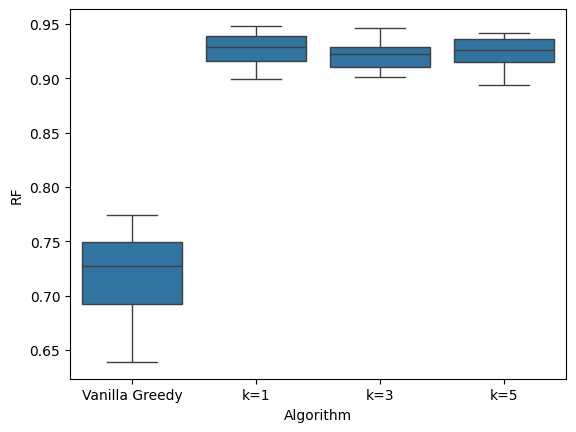

                count      mean       std       min       25%       50%  \
Algorithm                                                                 
Vanilla Greedy   10.0  0.719695  0.042739  0.639073  0.691922  0.727181   
k=1              10.0  0.927590  0.016015  0.899654  0.915793  0.928450   
k=3              10.0  0.920554  0.014527  0.900990  0.910705  0.922418   
k=5              10.0  0.923217  0.016589  0.893688  0.914576  0.925811   

                     75%       max  
Algorithm                           
Vanilla Greedy  0.749580  0.774306  
k=1             0.939345  0.948220  
k=3             0.929285  0.946578  
k=5             0.936336  0.941842  


In [5]:
# Robinson-Foulds Distance
algorithm_to_performance_rf_df = pd.DataFrame(columns=["Algorithm", "RF"])
for algorithm in algorithm_to_performance_rf:
    entries = algorithm_to_performance_rf[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["RF"] = entries

    algorithm_to_performance_rf_df = pd.concat([algorithm_to_performance_rf_df, new_df])

sns.boxplot(data=algorithm_to_performance_rf_df, x="Algorithm", y="RF")
plt.show()

rf_stats = algorithm_to_performance_rf_df.groupby("Algorithm")["RF"].describe()
print(rf_stats)